## Guitar classifier

Objective: build a deployable model trained to distinguish 4 classic electric guitar models.

In [1]:
import fastbook
import fastai.vision.widgets
import os
from dotenv import load_dotenv
from pathlib import Path

Place a .env file at the root of the repo containing an AZURE_SEARCH_KEY env variable.

It should contain the key to an __[Azure Bing Search API](https://portal.azure.com/#create/microsoft.bingsearch)__ key (free-tier available).

In [2]:
%%capture
notebook_path = Path(os.path.abspath(''))
repo_root = notebook_path.parent.parent
load_dotenv(repo_root / '.env')

Grab images from bing for each guitar model

In [3]:
guitar_models = {'fender stratocaster': None,
                 'fender telecaster': None,
                 'gibson les paul': None,
                 'gibson sg guitar': None}
fastbook.search_images_bing

<function fastbook.search_images_bing(key, term, min_sz=128, max_images=150)>

Pull down images into folders split by guitar model...

In [4]:
data_path = notebook_path / 'data'
data_path.mkdir(exist_ok=True)
for guit_key in guitar_models:
    images_path = data_path / guit_key
    images_path.mkdir(exist_ok=True)
    results = fastbook.search_images_bing(os.environ.get('AZURE_SEARCH_KEY'), guit_key)
    fastbook.download_images(images_path, urls=results.attrgot('contentUrl'))
    guitar_models[guit_key] = images_path

Clean up corrupt images, delete them, and count what's left...

In [5]:
for path in guitar_models.values():
    images = fastbook.get_image_files(path)
    corrupted = fastbook.verify_images(images)
    corrupted.map(Path.unlink)
    print(len(fastbook.get_image_files(path)))

144
142
146
143


Using data augmentation to "mix-up" the data, giving the model more to train on with a limited dataset.

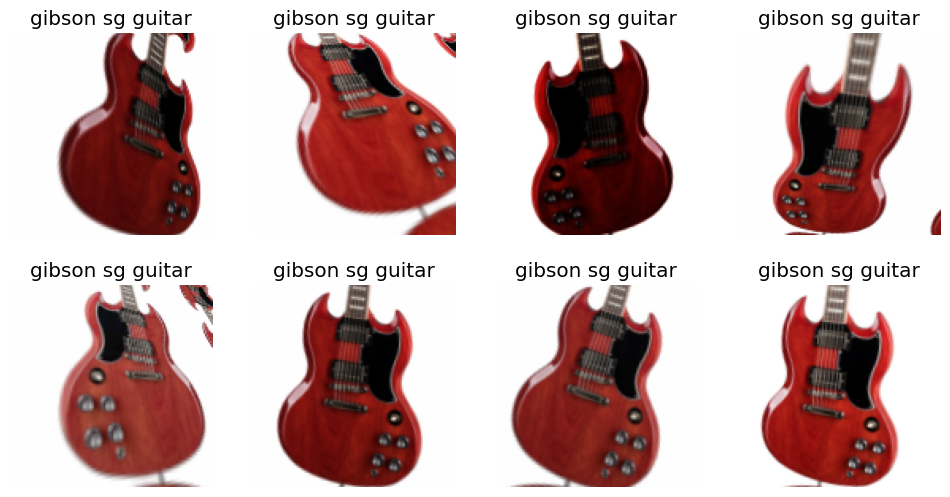

In [6]:
guitars = fastbook.DataBlock(
    blocks=(fastbook.ImageBlock, fastbook.CategoryBlock),
    get_items=fastbook.get_image_files,
    splitter=fastbook.RandomSplitter(valid_pct=0.2, seed=42),
    get_y=fastbook.parent_label,
    item_tfms=fastbook.Resize(128),
    batch_tfms=fastbook.aug_transforms(mult=2)
)
guitar_dataloaders = guitars.dataloaders(data_path)
guitar_dataloaders.train.show_batch(max_n=8, nrows=2, unique=True)

Expand the resolution and fine-tune a resnet18 model.

In [7]:
guitars = guitars.new(
    item_tfms=fastbook.RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=fastbook.aug_transforms())
guitar_dataloaders = guitars.dataloaders(data_path)
learner = fastbook.vision_learner(guitar_dataloaders, fastbook.resnet18, metrics=fastbook.error_rate)
learner.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.084521,1.446155,0.530435,00:43


epoch,train_loss,valid_loss,error_rate,time
0,0.942017,0.589854,0.260870,00:42
1,0.745943,0.359302,0.156522,00:42
2,0.589081,0.241416,0.095652,00:42
3,0.499562,0.216122,0.095652,00:42


Now I can take a look at the confusion matrix to see where I am possibly hitting errors.

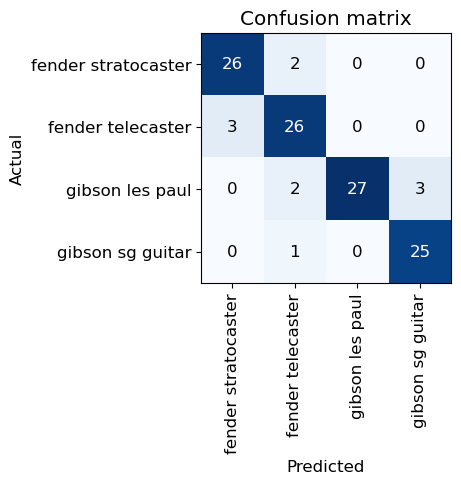

In [8]:
interpretation = fastbook.ClassificationInterpretation.from_learner(learner)
interpretation.plot_confusion_matrix()

Let's take a look at what the most off, best on the highest loss.

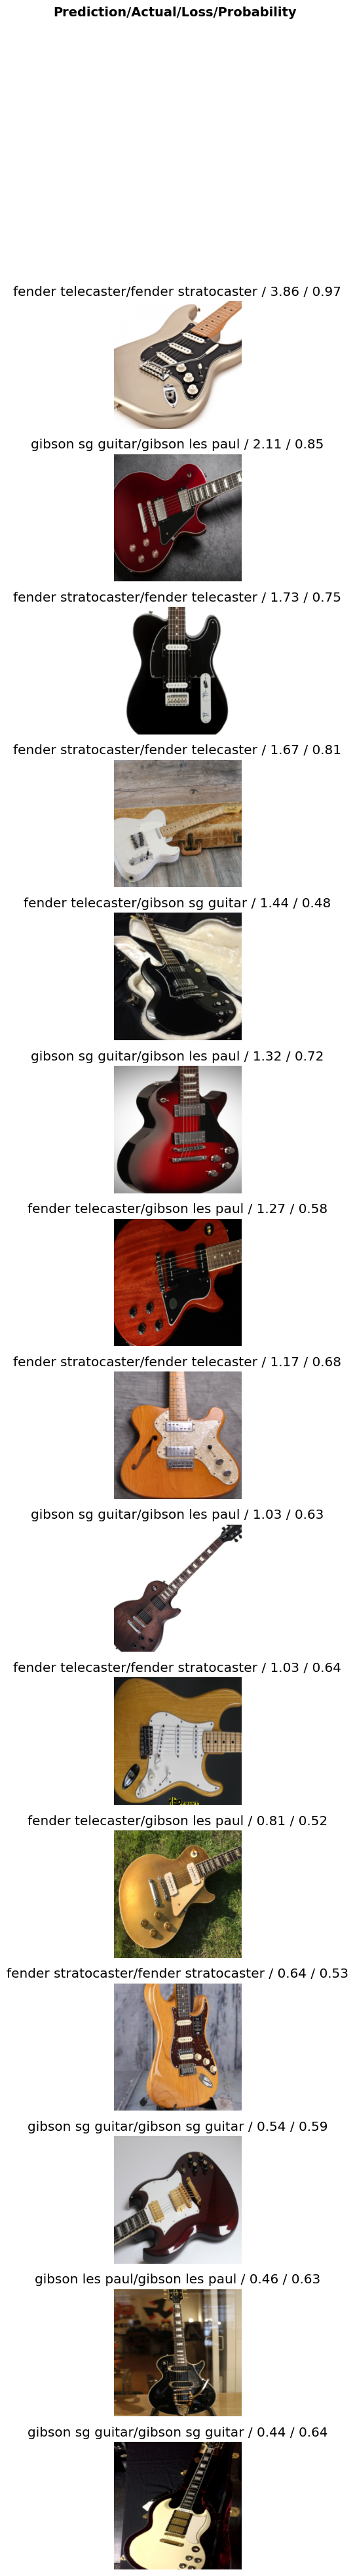

In [9]:
interpretation.plot_top_losses(15, nrows=15)

There are some things to clean up. You can use fastai's ImageClassifierCleaner but my experience was a little buggy and looking at thumbnails was quicker for me.

In [11]:
# #hide_output
# cleaner = fastai.vision.widgets.ImageClassifierCleaner(learner)
# cleaner

In [13]:
guitars = guitars.new(
    item_tfms=fastbook.RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=fastbook.aug_transforms())
guitar_dataloaders = guitars.dataloaders(data_path)
learner = fastbook.vision_learner(guitar_dataloaders, fastbook.resnet18, metrics=fastbook.error_rate)
learner.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.802610,1.210182,0.486726,00:41


epoch,train_loss,valid_loss,error_rate,time
0,0.925162,0.423588,0.168142,00:41
1,0.705682,0.206306,0.070796,00:41
2,0.530247,0.154295,0.061947,00:41
3,0.444093,0.147441,0.044248,00:41


Getting more accurate results now that the data is cleaned up.

In [14]:
learner.predict(notebook_path / 'test' / 'lespaul.jpg')

('gibson les paul',
 tensor(2),
 tensor([6.0395e-05, 6.1139e-04, 9.9931e-01, 2.1484e-05]))

In [15]:
learner.predict(notebook_path / 'test' / 'sg.jpg')

('gibson sg guitar',
 tensor(3),
 tensor([1.5044e-06, 8.2662e-07, 1.7645e-06, 1.0000e+00]))

In [16]:
learner.predict(notebook_path / 'test' / 'strat.jpg')

('fender stratocaster',
 tensor(0),
 tensor([9.8098e-01, 1.8383e-02, 2.2745e-05, 6.1913e-04]))

In [17]:
learner.predict(notebook_path / 'test' / 'tele.jpg')

('fender telecaster',
 tensor(1),
 tensor([1.1137e-05, 9.9955e-01, 4.2074e-04, 1.3578e-05]))

It's performing pretty well so time to export the model to a pickle file.

In [18]:
learner.export()